# Momentum and Quasi-Momentum Strategies

### Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
from scipy import fftpack
from matplotlib import pyplot as plt
from finance_byu.summarize import summary
from finance_byu.regtables import Regtable
import statsmodels.formula.api as smf

Instructions
Goal: merge stoccknames and msf/dsf

Look at stocknames data and the msf file (get a small snippet) and merge permno and date 
1. merge the sharecode collumn onto the dsf/msf file
2. filter on sharecode 10 or 11 This will give us common stock
3. filter stocks on small prices, take absolute value of prices

Look at diether's notes on fast loading


### Load the datasets

In [119]:
# Read in the data sets and convert the dates to datetime objects
def load_data(factor_filename, stock_filename):
    factorData = pd.read_csv(factor_filename)
    factorData["Date"] = pd.to_datetime(factorData["Date"], format = "%Y%m") + pd.offsets.MonthEnd(1)
    priceData = pd.read_csv(stock_filename, parse_dates=['caldt'])
    priceData = priceData.rename({'permno': 'Symbol', 'caldt': 'Date', 'ticker': 'Ticker', 'prc': 'Close', 'me': 'MarketEquity', 'ret': 'Return', 'shr': 'SharesOut'}, axis = 1)
    return factorData, priceData

In [120]:
factorData, priceData = load_data("factorData.csv", "dietherData.csv")

### Set Parameters

In [121]:
"""
Parameters:
1. reflect (boolean) - If true, the extension will reflect the data. If false, the extension will extrapolate the data
2. padding (float) -  the percent of the data to pad on each side of the window
3. fftDetail (int) - the number of frequencies to keep(inclusive of 0) in the Fourier Transform
4. windowsize (int) - the size of the window for the rolling Fourier Transform
5. start (int) - the number of time period to start from the beginning of the window to calculate the momentum
6. stop (int) - the number of time periods to stop from the end of the window to calculate the momentum
7. bins (int) - the number of bins to use in the sorting
"""

# Set our main parameters
reflect = True          # baseline = True
padding = 0.1           # baseline = 0.1                     
fftDetail = 2           # baseline is determined from display function
windowsize = 13         # baseline = one greater than stop 
start = 2               # baseline = 2 (normal momentum convention t-2 for months)
stop = 12               # baseline = 12 (normal momentum convention t-12 for months)
bins = 5                # baseline = 5
discont_lim = 1         # baseline = 1 (The minimum discontinuity allowed in the calculations)

### Define different discontinuity methods

In [226]:
# Baseline for no discontinuity
def no_discontinuity(data, cleaned):
    return 1

# Make a method that generates a discontinuity error score
def simple_discontinuity(data, cleaned):
    discontinuity = np.array(data) - np.array(cleaned)
    return np.linalg.norm(discontinuity,2) ** 2 # Arbitrary power to make the error more visible

# Make a method that biases the negative dips more than the positive dips
def biased_discontinuity(data, cleaned, bias = 2):
    discontinuity = np.array(data) - np.array(cleaned)
    discontinuity[discontinuity < 0] *= bias
    return np.linalg.norm(discontinuity,2) ** 2 # Arbitrary power to make the error more visible

def recent_discontinuity(data,cleaned):
    discontinuity = np.array(data) - np.array(cleaned)
    # construct a weight vector that is 1 for the most recent and 0 for the oldest
    weight = np.arange(len(discontinuity))
    weight = weight / weight[-1]
    discontinuity = discontinuity * weight
    return np.linalg.norm(discontinuity,2) ** 2

### Define functions for portfolio creation

In [123]:
# Extend the data by reflecting or extrapolating the data
def extend(samples, reflect = True, padding = padding):
    """A function necessary to accurately approximate the original data when applying the Fourier Transform filters
    Inputs:
        samples (list) - taken from dataframe
        reflect (boolean) - If true, the extension will reflect the data. If false, the extension will extrapolate the data
        padding (float) -  the percent of the data to pad on each side of the window
        """
    samples = np.array(samples)
    
    # get the first and last k samples
    k = int(len(samples) * padding)
    rightend = samples[-k:] 
    leftend = samples[:k]
    
    # get the first and last endpoints
    rightendpoint = samples[-1]
    leftendpoint = samples[0]

    # reverse the order of left end and right end based on the type of extension
    if reflect:
        leftend = leftend[::-1]
        rightend = rightend[::-1]

    else:
        leftend = 2*leftendpoint - leftend[::-1]
        rightend = 2*rightendpoint - rightend[::-1]

    # concatenate the left end, samples, and right end
    extendedsamples = np.concatenate((leftend, samples, rightend))
    return extendedsamples


# Repeat the rolling forier transform for each stock but discount by the continuity error
def general_rolling(samples, discontinuity = no_discontinuity, fftDetail = fftDetail, windowsize = windowsize, 
                    start = start, stop = stop, padding = padding, discont_lim = discont_lim, var_filter = False):
    """A rolling function that will calculate a fourier transform and momentum score for each rolling window
    Inputs:
        1. samples (list) - taken from dataframe
        2. discontinuity (function) - the function to use to calculate the discontinuity error
        3. fftDetail (int) - the number of frequencies to keep(inclusive of 0) in the Fourier Transform
        4. windowsize (int) - the size of the window for the rolling Fourier Transform
        5. start (int) - the number of time period to start from the beginning of the window to calculate the momentum
        6. stop (int) - the number of time periods to stop from the end of the window to calculate the momentum
        7. padding (float) -  the percent of the data to pad on each side of the window
        """
    
    # if the window is larger than the number of samples, return nans
    if len(samples) < windowsize:
        return np.full(len(samples),np.nan).tolist()
    
    # make a list to hold the cleaned samples
    k = int(windowsize * padding)
    cleansamples = []

    # loop through the samples and take the fft of the window as it rolls
    for i in range(len(samples) - windowsize):
        # Get the correct window, extend the data, take the fft, and clean it
        data = samples[i:i+windowsize]
        extendeddata = extend(data)
        fft = fftpack.fft(extendeddata)
        fft[fftDetail:-fftDetail] = 0
        cleaned = np.real(fftpack.ifft(fft))[k:-k]

        #calculate the momentum of the cleaned data and append it to the list
        returns = np.diff(cleaned) / cleaned[:-1]
        returns = np.insert(returns, 0, np.nan)
        logreturns = np.log(1 + returns)
        momentum = np.sum(logreturns[-stop:-start])

        # If the variance filter is true, then discount by the variance of the returns
        if var_filter:
            momentum /= np.var(returns)

        # Make the calculate the discontinuity error and discount by it if it is less than the limit
        else:   
            discontinuityerror = discontinuity(data, cleaned)
            if discontinuityerror < discont_lim:
                discontinuityerror = discont_lim
            momentum /= discontinuityerror

        # append the momentum to the list
        cleansamples.append(momentum)
    # insert nans to make the list the same length as the original
    return np.full(windowsize, np.nan).tolist() + cleansamples



def bin_method(data, bins = bins, benchmark = True, score_name = "Benchmark", bin_name = "BenchBins",  discontinuity = no_discontinuity, 
        fftDetail = fftDetail, windowsize = windowsize, start = start, stop = stop, padding = padding, var_filter = False, var_bench = False):
    """Make a function that forms portfolios based on the momentum score and method strategy
    Inputs:
        1. bins (int) - the number of bins to use in the sorting
        2. benchmark (boolean) - if true, the benchmark momentum will be calculated. If false, the variation of momentum will be calculated
        3. score_name (string) - the name of the column to store the momentum score
        4. bin_name (string) - the name of the column to store the bin number
        5. discontinuity (function) - the function to use to calculate the discontinuity error
        **kwargs - the parameters to pass to the rolling fourier transform function
    Outputs:
        1. methodData (dataframe) - the data with the momentum score and bin number
        2. binData (dataframe) - the data with the average return of each bin"""
    
    # Calculate the benchmark momentum if benchmark is true and if the variance discounting method is false
    if benchmark or var_bench:
        data['LogRet'] = np.log(1 + data['Return'])
        data['Benchmark'] = data.groupby('Symbol')['LogRet'].rolling(stop - 1,stop - 1).sum().reset_index(drop=True)
        data['Benchmark'] = data.groupby('Symbol')['Benchmark'].shift(start)
        del data['LogRet']
        
        # Divide the regular momentum benchmark by the variance of the returns if var_bench is true
        if var_bench:
            data['VarReturns'] = data.groupby('Symbol')['Return'].rolling(stop - 1,stop - 1).var().reset_index(drop=True)
            data['VarReturns'] = data.groupby('Symbol')['VarReturns'].shift(start)
            data['VarBench'] = data['Benchmark']
            data['VarBench'] /= data['VarReturns']
            del data['VarReturns']
            score_name = 'VarBench'
            bin_name = 'VarBins'

    # Calculate the variation of momentum
    else:
        data[score_name] = data.groupby('Symbol')['Close'].transform(general_rolling, discontinuity = discontinuity, fftDetail = fftDetail, 
                                                    windowsize = windowsize, start = start, stop = stop, padding = padding, var_filter = var_filter)
    
    # Copy the data and drop all stocks less than $5
    data['CloseLag'] = data.groupby('Symbol')['Close'].shift()
    data = data.query("CloseLag >= 5").reset_index(drop=True)
    del data['CloseLag']

    # Drop all stocks with nans and split the score into the correct number of bins
    data = data.query(score_name+" == "+score_name).reset_index(drop=True)
    data[bin_name] = data.groupby('Date')[score_name].transform(pd.qcut,bins,labels=False)
    
    # Generate the portfolio returns and the spread
    MethodPortfolio = data.groupby(['Date', bin_name])['Return'].mean().unstack(level= bin_name)*100
    MethodPortfolio['Spread'] = MethodPortfolio[bins - 1] - MethodPortfolio[0]
    MethodPortfolio.columns = ['P' + str(i) for i in range(bins)] + ['Spread']
    return data, MethodPortfolio

def summary_results(Portfolio):
    display = summary(Portfolio).loc[['count', 'mean', 'std', 'tstat', 'pval']].round(3)
    display.loc['mean/std'] = display.loc['mean'] / display.loc['std']
    return display.round(3)


### Evaluate Parameters

In [124]:
def show_stock(priceData, granularity, windowsize, identifier = None, show_discontinuity = False):
    """
    Display the cleaned data in the most recent window size compared to the original stock.

    Args:
    - priceData (DataFrame): The DataFrame containing the price data.
    - windowsize (int): The size of the window for the rolling Fourier Transform.
    - startdate (str): The start date for the data to be displayed.
    - identifier (int): The identifier of the stock.

    Returns:
    - None
    """
    # If no identifier is given, take a random stock that has more observations than the window size
    if identifier is None:
        while True:
            identifier = priceData['Symbol'].sample().iloc[0]
            if len(priceData.query("Symbol == @identifier")) > windowsize:
                break


    # Get the data for the stock
    data = priceData.query("Symbol == @identifier").sort_values('Date').reset_index(drop=True)

    # Get the most recent window size and extend the data
    data = data.iloc[-windowsize:].reset_index(drop=True)
    data = data['Close'].tolist()
    k = int(windowsize * padding)
    extendeddata = extend(data)

    # Take the fft and clean it
    fft = fftpack.fft(extendeddata)
    fft[granularity:-granularity] = 0
    cleaned = np.real(fftpack.ifft(fft))[k:-k]

    # Plot the data
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(10,5))
    plt.title("Cleaned vs Original (window size = " + str(windowsize) + ", granularity = " + str(granularity) + ")", fontsize=15, fontweight='bold')
    plt.plot(data, label = "Original")
    plt.plot(cleaned, label = "Cleaned")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plot the difference between them squared (the discontinuity)
    if show_discontinuity:
        plt.figure(figsize=(10,5))
        plt.title("Discontinuity (window size = " + str(windowsize) + ", granularity = " + str(granularity) + ")", fontsize=15, fontweight='bold')
        plt.plot((np.array(data) - np.array(cleaned)) ** 2 / np.mean(data)**2, label = "Discontinuity")
        plt.tight_layout()
        plt.show()

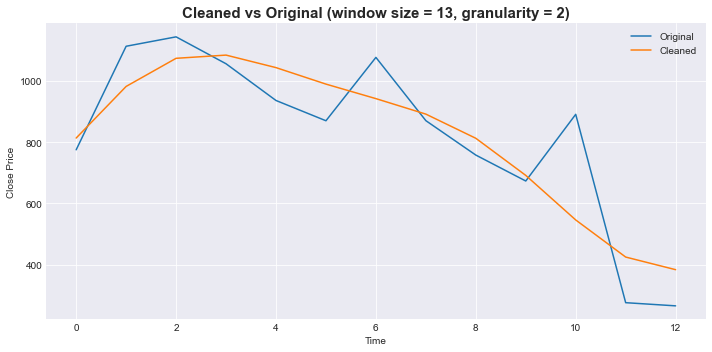

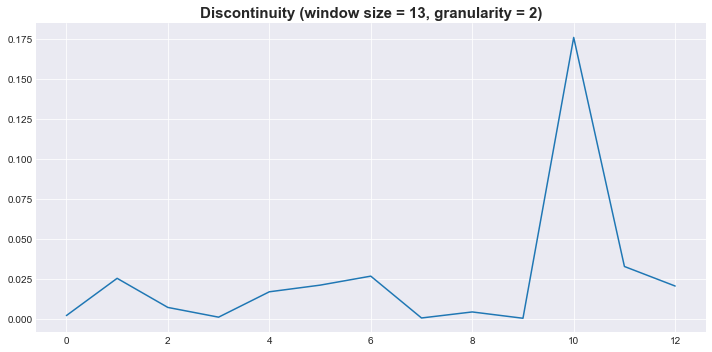

In [125]:
# Show the granularity of the last window of tesla, Symbol of 93436
identifier = 93436
granularity = 2
windowsize = 13

show_stock(priceData, granularity, windowsize, identifier, show_discontinuity = True)

### Generate Portfolios

In [126]:
BenchmarkData, BenchmarkPortfolio = bin_method(priceData)


In [127]:
VarBenchData, VarBenchPortfolio = bin_method(priceData,var_bench=True)

In [128]:
SimpleData, SimplePortfolio = bin_method(priceData, bins, False, "FFTMomentum", "FFTBins", no_discontinuity)

/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_95357/2788977988.py:68: RuntimeWarning: invalid value encountered in log
  logreturns = np.log(1 + returns)


In [129]:
DiscontinuityData, DiscontinuityPortfolio = bin_method(priceData, bins, False, "DiscontinuityMomentum", "DiscontinuityBins", simple_discontinuity)

/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_95357/2788977988.py:68: RuntimeWarning: invalid value encountered in log
  logreturns = np.log(1 + returns)


### Performances Summaries

In [130]:
summary_results(BenchmarkPortfolio)

,P0,P1,P2,P3,P4,Spread
count,711.000,711.000,711.000,711.000,711.000,711.000
mean,0.408,0.950,1.137,1.306,1.619,1.211
std,6.768,5.142,4.687,4.826,6.322,4.553
tstat,1.607,4.929,6.466,7.218,6.826,7.089
pval,0.108,0.000,0.000,0.000,0.000,0.000
mean/std,0.060,0.185,0.243,0.271,0.256,0.266


In [131]:
summary_results(VarBenchPortfolio)

,P0,P1,P2,P3,P4,Spread
count,711.000,711.000,711.000,711.000,711.000,711.000
mean,0.445,0.793,1.208,1.490,1.483,1.038
std,5.668,6.087,5.916,5.381,4.310,3.333
tstat,2.095,3.475,5.446,7.380,9.178,8.305
pval,0.037,0.001,0.000,0.000,0.000,0.000
mean/std,0.079,0.130,0.204,0.277,0.344,0.311


In [132]:
summary_results(SimplePortfolio)

,P0,P1,P2,P3,P4,Spread
count,710.000,710.000,710.000,710.000,710.000,710.000
mean,0.496,0.964,1.129,1.296,1.565,1.069
std,6.595,5.181,4.687,4.844,6.263,4.093
tstat,2.005,4.959,6.420,7.127,6.660,6.960
pval,0.045,0.000,0.000,0.000,0.000,0.000
mean/std,0.075,0.186,0.241,0.268,0.250,0.261


In [133]:
summary_results(DiscontinuityPortfolio)

,P0,P1,P2,P3,P4,Spread
count,710.000,710.000,710.000,710.000,710.000,710.000
mean,0.606,0.853,1.104,1.293,1.596,0.990
std,5.378,5.698,5.627,5.453,5.296,2.625
tstat,3.002,3.988,5.227,6.317,8.028,10.043
pval,0.003,0.000,0.000,0.000,0.000,0.000
mean/std,0.113,0.150,0.196,0.237,0.301,0.377


In [227]:
# expiramentdata, expiramentportfolio = bin_method(priceData, bins, False, "RecentDiscontinuity", "RecentBins", recent_discontinuity)
# summary_results(expiramentportfolio)

/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_95357/2788977988.py:68: RuntimeWarning: invalid value encountered in log
  logreturns = np.log(1 + returns)


,P0,P1,P2,P3,P4,Spread
count,710.000,710.000,710.000,710.000,710.000,710.000
mean,0.573,0.873,1.110,1.322,1.574,1.001
std,5.459,5.655,5.581,5.430,5.305,2.644
tstat,2.796,4.114,5.298,6.485,7.905,10.088
pval,0.005,0.000,0.000,0.000,0.000,0.000
mean/std,0.105,0.154,0.199,0.243,0.297,0.379


### Performance Plotting Functions

In [175]:
def historical_returns(Portfolios, Titles, start=None, end=None, frequency='Y'):
    """Aggregate the spread portfolio returns and plot them
    Inputs:
        1. Portfolios (list) - a list of dataframes with the spread portfolio returns
        2. Titles (list) - a list of strings with the titles of the portfolios
        3. start (int) - the year to start the plot
        4. end (int) - the year to end the plot
        5. frequency (string) - the frequency to aggregate the returns"""

    # Raise an error if the number of portfolios and titles don't match and if the number of portfolios is empty
    if len(Portfolios) != len(Titles):
        raise ValueError("The number of portfolios and titles must match")
    if len(Portfolios) == 0:
        raise ValueError("There must be at least one portfolio")

    # Initialize the plotlist, get number of Portfolios, and loop through the portfolios
    n = len(Portfolios)
    plotlist = []
    for port in Portfolios:
        plotlist.append(port.groupby(pd.Grouper(freq=frequency)).mean()[1:])

    # Get the max and min of all portfolios to set the y axis and give a 10% buffer
    smallest = min([port['Spread'].min() for port in plotlist])
    largest = max([port['Spread'].max() for port in plotlist])
    range = largest - smallest
    buffer = range * .1
    ymin = smallest - buffer
    ymax = largest + buffer

    # Set the x axis
    first_date = min([port.index.min() for port in plotlist]).year
    last_date = max([port.index.max() for port in plotlist]).year

    # Set the start and end dates if they are not given correctly
    if start is None or start < first_date or start > last_date:
        start = first_date
    if end is None or end > last_date or end < first_date:
        end = last_date

    # Initialize the plot
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(12, n * 4))
    fig.suptitle('Momentum and Quasi-Momentum Performance', fontsize=17, fontweight='bold')
    fig.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(top=0.92)

    # generate the x axis that are the last two digits of the year
    x = np.arange(start, end + 1, 1)
    x = [str(i)[-2:] for i in x]

    # Create subplots
    for i, port in enumerate(plotlist):
        ax = fig.add_subplot(n, 1, i+1)

        # Plotting the bar chart
        ax.bar(x, port['Spread'], color='steelblue')

        # Adding title and labels
        ax.set_title(Titles[i], fontsize=14, fontweight='bold', fontstyle = 'italic')
        ax.set_ylabel('Returns %', fontsize=13, fontstyle = 'italic')

        # Setting the font style and adjust the grid so it is shifted to line up with the bars
        ax.tick_params(axis='both', labelsize=11, pad=5)
        for spine in ax.spines.values():
            spine.set_visible(False)

        # make the ends of the graph not be empty
        ax.set_xlim(left=-.7, right=len(x) - .3 )


        # Setting the y-axis limits and adjust the grid
        ax.set_ylim(ymin, ymax)
        ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

        # Make the x axis labels more readable if it is too crowded
        if len(x) > 26:
            ax.xaxis.set_major_locator(plt.MaxNLocator(26))

    # Add a footnote for the entire plot
    fig.text(0.08, -0.02, 'Source: Your data source', fontsize=8, color='gray')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [171]:
def plot_distribution(dataframes, methods, trim = None, bins = 50):
    """Make a histogram of the different methods distributions
    Inputs:
        1. latest_data (dataframe) - the data to plot
        2. methods (list of strings) - the methods to plot
        3. trim (float) - the amount to trim the data by
        4. bins (int) - the number of bins to use in the histogram"""
    
    # Get the number of methods and set the figure
    n = len(methods)
    plt.figure(figsize=(8,4 * n))

    # Loop through the methods
    for df, name in zip(dataframes, methods):
        # Get the correct suplot and title
        plt.subplot(len(methods), 1, methods.index(name) + 1)
        plt.title("'" + name + "' Distribution", fontsize=15, fontweight='bold')

        # Get the data and trim it if it is given
        data = df[name]
        if trim is not None:
            data = data[(data > -trim) & (data < trim)]
            plt.gca().set_xlim(-trim, trim)
        # exclude the top .5% and bottom .5% of data
        else:
            data = data[(data > data.quantile(0.01)) & (data < data.quantile(0.99))]
            plt.gca().set_xlim(data.quantile(0.01), data.quantile(0.99))
            

        # Get the size of the data and plot it
        size = len(data)
        plt.hist(data, bins = bins, label = name, alpha = 0.5)
        
        # normalize the y axis to be a percentage of the total (0 to 100%)
        vals = np.linspace(0, size, 11)
        plt.gca().set_yticklabels(['{:.0f}%'.format(x*100/size) for x in vals])

        # make a dotted vertical red line at the mean
        plt.axvline(data.mean(), color='r', linestyle='dashed', linewidth=2)

        # make a dotted vertical black line at 0, and label it as 0 on the graph
        plt.axvline(0, color='k', linestyle='dashed', linewidth=2)

    # Make the plot neat and display it
    plt.tight_layout()
    plt.show()

In [136]:
def display_price(id):
    """Display the price data for a stock
    Inputs:
        1. id (int) - the identifier of the stock"""
    # Get the data for the stock
    data = priceData[priceData['Symbol'] == id].sort_values('Date').reset_index(drop=True)

    # plot the data
    plt.figure(figsize=(10,5))
    plt.title("Price Data for: " + str(id), fontsize=15, fontweight='bold')
    plt.plot(data['Close'], label = "Close")

### Display Performances

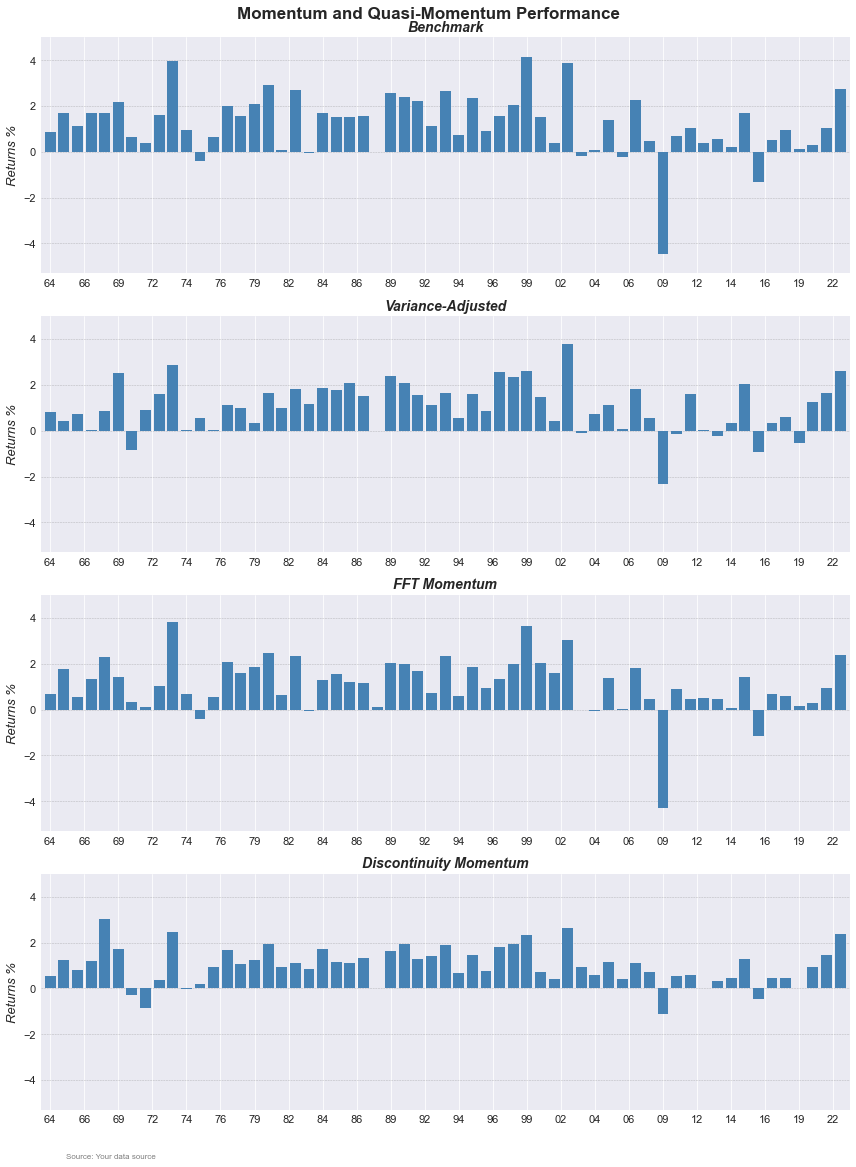

In [176]:
portfolios = [BenchmarkPortfolio, VarBenchPortfolio, SimplePortfolio, DiscontinuityPortfolio]
historical_returns(portfolios, ['Benchmark', 'Variance-Adjusted','FFT Momentum', 'Discontinuity Momentum'],1,1)

/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_95357/518902164.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100/size) for x in vals])


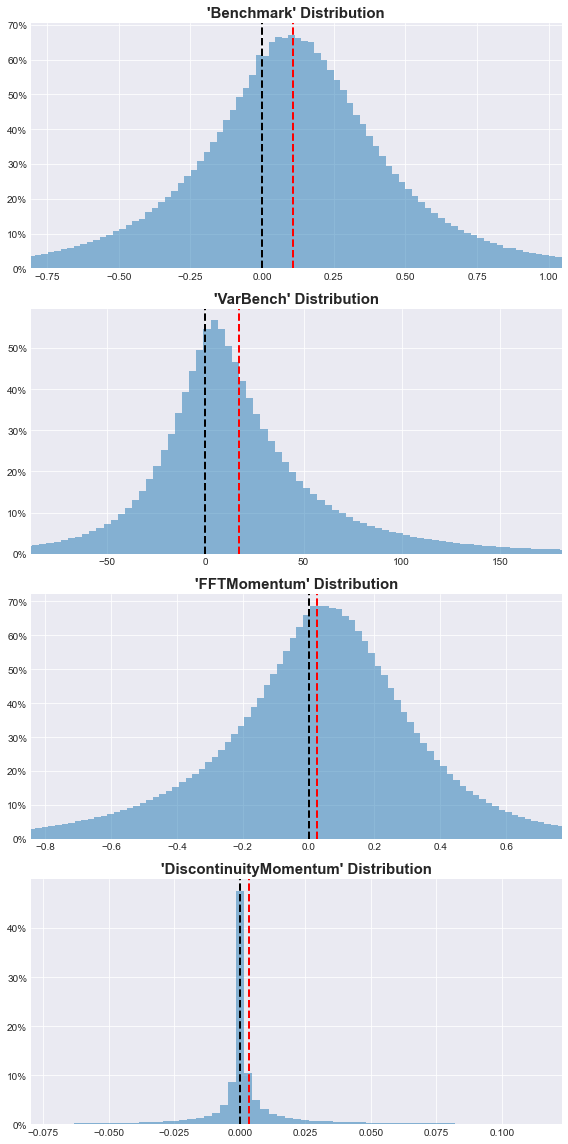

In [173]:
dataframes = [BenchmarkData, VarBenchData, SimpleData, DiscontinuityData]
methods = ["Benchmark", "VarBench", "FFTMomentum", "DiscontinuityMomentum"]
plot_distribution(dataframes, methods, bins = 100)

### Market Analysis Functions

In [212]:
def join_data(portfolio, factorData):
    """Join the portfolio data with the factor data
    Inputs:
        1. portfolio (list) - a list of dataframes with the portfolio returns
        2. factorData (dataframe) - the dataframe with the factor data"""
    # Initialize the list to hold the joined data and loop through the portfolios
    joined = []
    for port in portfolio:
        # Convert the dates to datetime objects and merge the data
        port.index = pd.to_datetime(port.index)
        port = port.merge(factorData, how = 'left', on = 'Date').dropna()

        # Calculate the excess returns and append the data to the list
        port[[f'Excess{i}' for i in range(bins)]] = port[[f'P{i}' for i in range(bins)]].sub(port['RiskFreeRate'], axis = 'index')
        port['ExcessSpread'] = port['Spread'].sub(port['RiskFreeRate'], axis = 'index')
        joined.append(port)
    
    # Return the joined data
    return joined

def analysis(joined, names):
    """Analyze the data using the CAPM and 3-Factor Model
    Inputs:
        1. joined (list) - a list of dataframes with the joined data (first item must be the benchmark portfolio)
        2. names (list) - a list of strings with the names of the portfolios
    Outputs:
        1. Reg (dataframe) - a dataframe with the CAPM results
        2. Factor (dataframe) - a dataframe with the 3-Factor results"""
    # Get the excess returns and the market excess returns
    capm = [port['ExcessSpread'].rename(names[i]) for i, port in enumerate(joined)]
    capm.append(joined[0][['ExcessMkt']])
    
    # Analyze CAPM Factor Model
    CAPMtest = pd.concat(capm, axis = 1).dropna()
    Reg = Regtable([smf.ols(f'{i} ~ ExcessMkt', data = CAPMtest).fit() for i in list(CAPMtest.columns)[:-1]], stat = 'tstat', sig = 'coeff').render()

    # Analyze Factor model
    capm.append(joined[0][['SMB', 'HML']])
    FactorTest = pd.concat(capm, axis = 1).dropna()
    Factor = Regtable([smf.ols(f'{i} ~ 1 + ExcessMkt + SMB + HML', data = FactorTest).fit() for i in list(FactorTest.columns)[:-3]], stat = 'tstat', sig = 'coeff').render()

    # Give each table a title in the actual table
    Reg.columns.name = 'CAPM Test'
    Factor.columns.name = '3-Factor Test'

    # Make the order of the columns be the same as the names
    Reg = Reg[names]
    print(Factor.columns)
    Factor = Factor[names]

    # Return the tables
    return Reg, Factor

### Run Market Analysis

In [213]:
portfolios = [BenchmarkPortfolio, VarBenchPortfolio, SimplePortfolio, DiscontinuityPortfolio]
joined = join_data(portfolios, factorData)
names = ['Benchmark', 'VarBench', 'FFT', 'Discontinuity']
Reg, Factor = analysis(joined, names)

Index(['Benchmark', 'VarBench', 'FFT', 'Discontinuity'], dtype='object', name='3-Factor Test')


/Users/samlayton/opt/anaconda3/lib/python3.9/site-packages/finance_byu/regtables.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(obs)
/Users/samlayton/opt/anaconda3/lib/python3.9/site-packages/finance_byu/regtables.py:178: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(rsqs)
/Users/samlayton/opt/anaconda3/lib/python3.9/site-packages/finance_byu/regtables.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(obs)
/Users/samlayton/opt/anaconda3/lib/python3.9/site-packages/finance_byu/regtables.py:178: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = out.append(rsqs)


In [214]:
Reg

CAPM Test,Benchmark,VarBench,FFT,Discontinuity
,,,,
Intercept,0.807***,0.754***,0.858***,0.791***
,(2.76),(3.80),(3.33),(5.14)
ExcessMkt,-0.057,-0.231***,-0.088,-0.001
,(-0.88),(-5.27),(-1.55),(-0.04)
Obs,298,298,298,298
Rsq,0.00,0.09,0.01,0.00


In [215]:
Factor

3-Factor Test,Benchmark,VarBench,FFT,Discontinuity
,,,,
Intercept,1.013***,0.912***,0.835***,0.742***
,(3.60),(4.69),(3.19),(4.79)
ExcessMkt,-0.160**,-0.224***,-0.102,-0.022
,(-2.44),(-4.94),(-1.67),(-0.60)
SMB,0.190**,-0.158**,0.067,0.112**
,(2.12),(-2.55),(0.80),(2.27)
HML,-0.483***,-0.302***,0.034,0.080
,(-5.00),(-4.52),(0.37),(1.49)
Obs,298,298,298,298


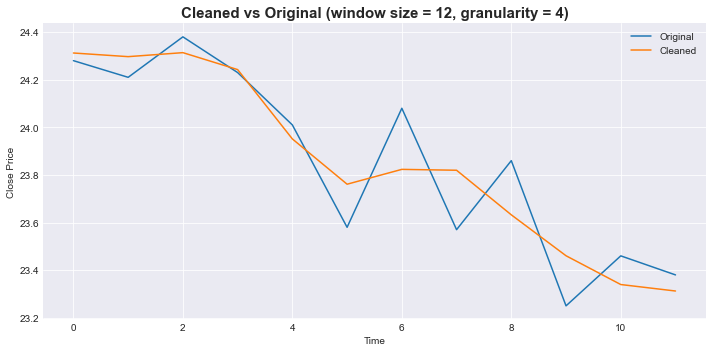

In [371]:
tester = pd.read_csv('all_stocks_5yr.csv')
# rename the column name to Symbol
tester.rename(columns={'Name':'Symbol', 'close':'Close', 'date':'Date', 'open':'Open', 'high':'High','low':'Low', 'volume':'Volume'}, inplace=True)
tester

show_stock(tester,4, 12)

# convert the date column to datetime
tester['Date'] = pd.to_datetime(tester['Date'])




In [267]:
import pandas as pd



def get_weekly(dataset):
    # Set 'Date' as the index
    df = dataset.copy()
    df.set_index('Date', inplace=True)

    # Resample to weekly and monthly frequency
    weekly_df = df.resample('W').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    return weekly_df

def get_monthly(dataset):
    # Set 'Date' as the index
    df = dataset.copy()
    df.set_index('Date', inplace=True)
    # Resample to weekly and monthly frequency
    monthly_df = df.resample('M').apply({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
    })

    return monthly_df









ValueError: MultiIndex has no single backing array. Use 'MultiIndex.to_numpy()' to get a NumPy array of tuples.

In [260]:
import pandas as pd

# Sample daily stock data with multiple symbols
data = {
    'Date': ['2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04', '2023-08-05', '2023-08-08', '2023-08-09', '2023-08-10',
             '2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04', '2023-08-05', '2023-08-08', '2023-08-09', '2023-08-10'],
    'Symbol': ['AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL',
               'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT'],
    'Open': [150.0, 151.5, 152.0, 150.5, 152.5, 153.0, 152.5, 153.5,
             300.0, 302.5, 305.0, 301.5, 303.5, 304.0, 303.5, 305.0],
    'High': [152.0, 153.0, 154.5, 152.5, 154.0, 155.0, 154.0, 155.5,
             305.0, 307.0, 308.5, 305.5, 306.5, 308.0, 307.5, 308.0],
    'Low': [149.5, 150.5, 151.0, 150.0, 151.5, 151.0, 151.0, 152.5,
            298.0, 300.5, 302.0, 300.0, 301.5, 302.0, 301.0, 303.0],
    'Close': [151.5, 152.5, 153.5, 152.0, 153.5, 154.5, 153.5, 155.0,
              303.0, 305.5, 307.0, 304.5, 305.5, 306.5, 305.0, 307.0],
    'Volume': [100000, 120000, 110000, 105000, 130000, 115000, 112000, 118000,
               150000, 140000, 130000, 135000, 125000, 120000, 130000, 140000]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' and 'Symbol' as the index
df.set_index(['Symbol', 'Date'], inplace=True)
print("hi")

# Group by 'Symbol' before resampling to weekly and monthly frequency
weekly_df = df.groupby('Symbol').resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

monthly_df = df.groupby('Symbol').resample('M').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

print("Weekly Stock Data:")
print(weekly_df)

print("\nMonthly Stock Data:")
print(monthly_df)

hi


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'

In [378]:
def run(a,b):
    return a+b

def sweep_weekly():
    sweeps = {13:[2,3], 26:[3,4,5], 39:[4,7,10], 52:[4,8,12]}
    weekly_sweep = np.full_like(np.zeros((4,3)), np.nan)
    for i, window in enumerate(sweeps.keys()):
        for j, granularity in enumerate(sweeps[window]):
            weekly_sweep[i,j] = run(window, granularity)
    return weekly_sweep


def sweep_monthly():
    sweeps = {12:[1,2,3]}
    monthly_sweep = np.full_like(np.zeros((1,3)), np.nan)
    for i, window in enumerate(sweeps.keys()):
        for j, granularity in enumerate(sweeps[window]):
            monthly_sweep[i,j] = run(window, granularity)
    return monthly_sweep

    
sweep_weekly()

array([[15., 16., nan],
       [29., 30., 31.],
       [43., 46., 49.],
       [56., 60., 64.]])